In [1]:
!pip uninstall -y imbalanced-learn scikit-learn -q
!pip install scikit-learn==1.3.2 imbalanced-learn==0.11.0 -q
!pip install sdv -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 77.5 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 10.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.3.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.5/198.5 kB 4.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB

# Thư viện và các hằng số

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sdv.single_table import CTGANSynthesizer, TVAESynthesizer
from sdv.metadata import SingleTableMetadata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import xgboost as xgb
from sklearn.utils import shuffle
import math
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# FILE_PATH = '/kaggle/input/creditcardfraud/creditcard.csv'
FILE_PATH = 'creditcard.csv'
THRESHOLD = 0.65
RANDOM_STATE = 42

# Lấy dữ liệu và kiểm tra

In [4]:
df = pd.read_csv(FILE_PATH)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


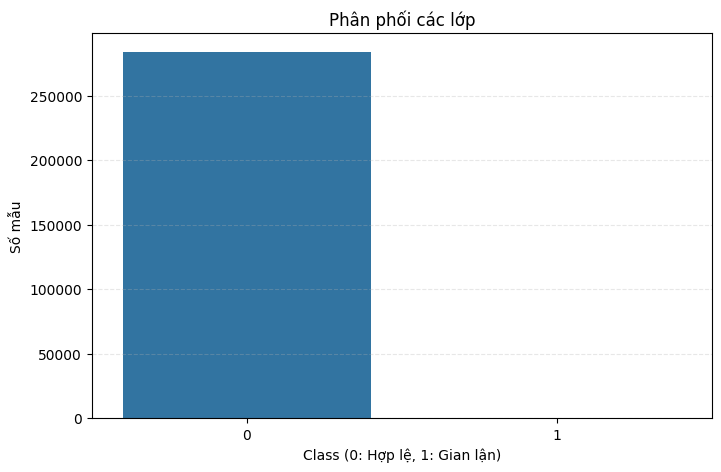

Số lượng mẫu có nhãn 0: 284315
Số lượng mẫu có nhãn 1: 492


In [5]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df['Class'])

plt.title("Phân phối các lớp")
plt.xlabel("Class (0: Hợp lệ, 1: Gian lận)")
plt.ylabel("Số mẫu")
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.show()

print(f'Số lượng mẫu có nhãn 0: {(df["Class"] == 0).sum()}')
print(f'Số lượng mẫu có nhãn 1: {(df["Class"] == 1).sum()}')

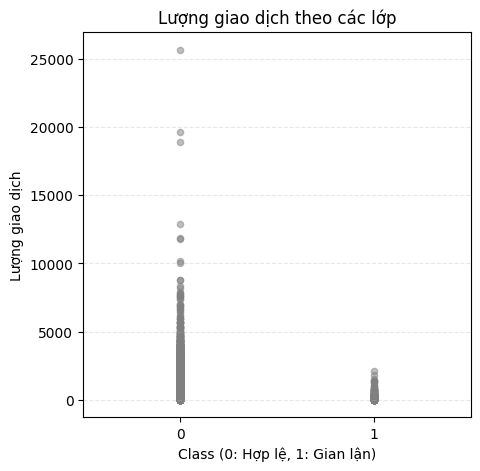

In [6]:
plt.figure(figsize=(5, 5))

# Lấy dữ liệu theo từng class
class0 = df[df["Class"] == 0]["Amount"]
class1 = df[df["Class"] == 1]["Amount"]

# Vẽ scatter thẳng hàng
plt.scatter([0]*len(class0), class0, alpha=0.5, s=20, color='gray')
plt.scatter([1]*len(class1), class1, alpha=0.5, s=20, color='gray')

plt.title("Lượng giao dịch theo các lớp")
plt.xlabel("Class (0: Hợp lệ, 1: Gian lận)")
plt.ylabel("Lượng giao dịch")

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.xticks([0, 1], ["0", "1"], fontsize=10)
plt.xlim(-0.5, 1.5)

plt.show()

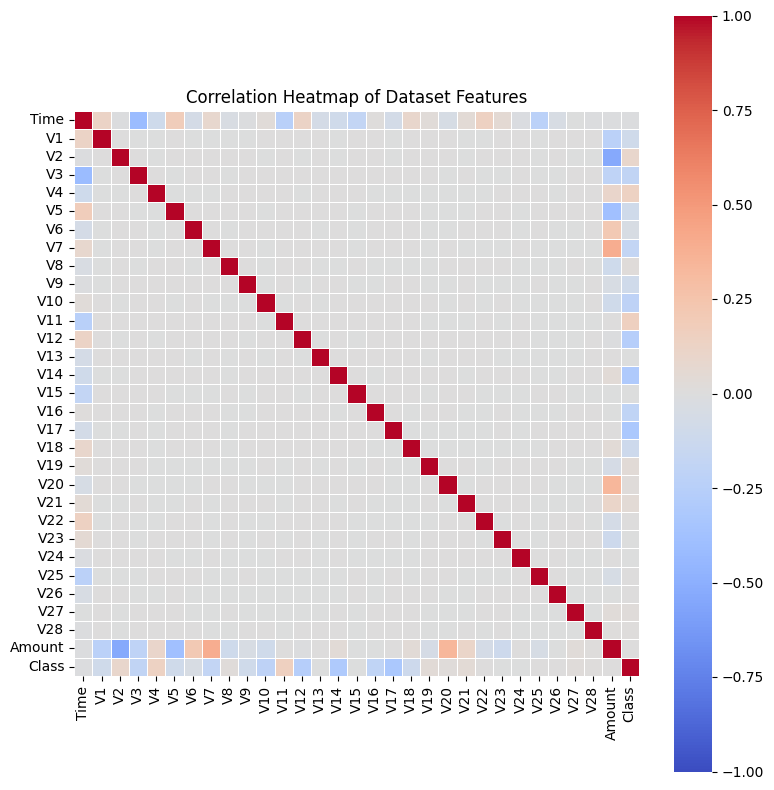

In [7]:
plt.figure(figsize=(8, 8))

corr = df.corr(numeric_only=True)

sns.heatmap(
    corr,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    center=0,
    annot=False,
    linewidths=0.5,
    square=True,
    cbar=True
)

plt.title("Correlation Heatmap of Dataset Features")
plt.tight_layout()
plt.show()

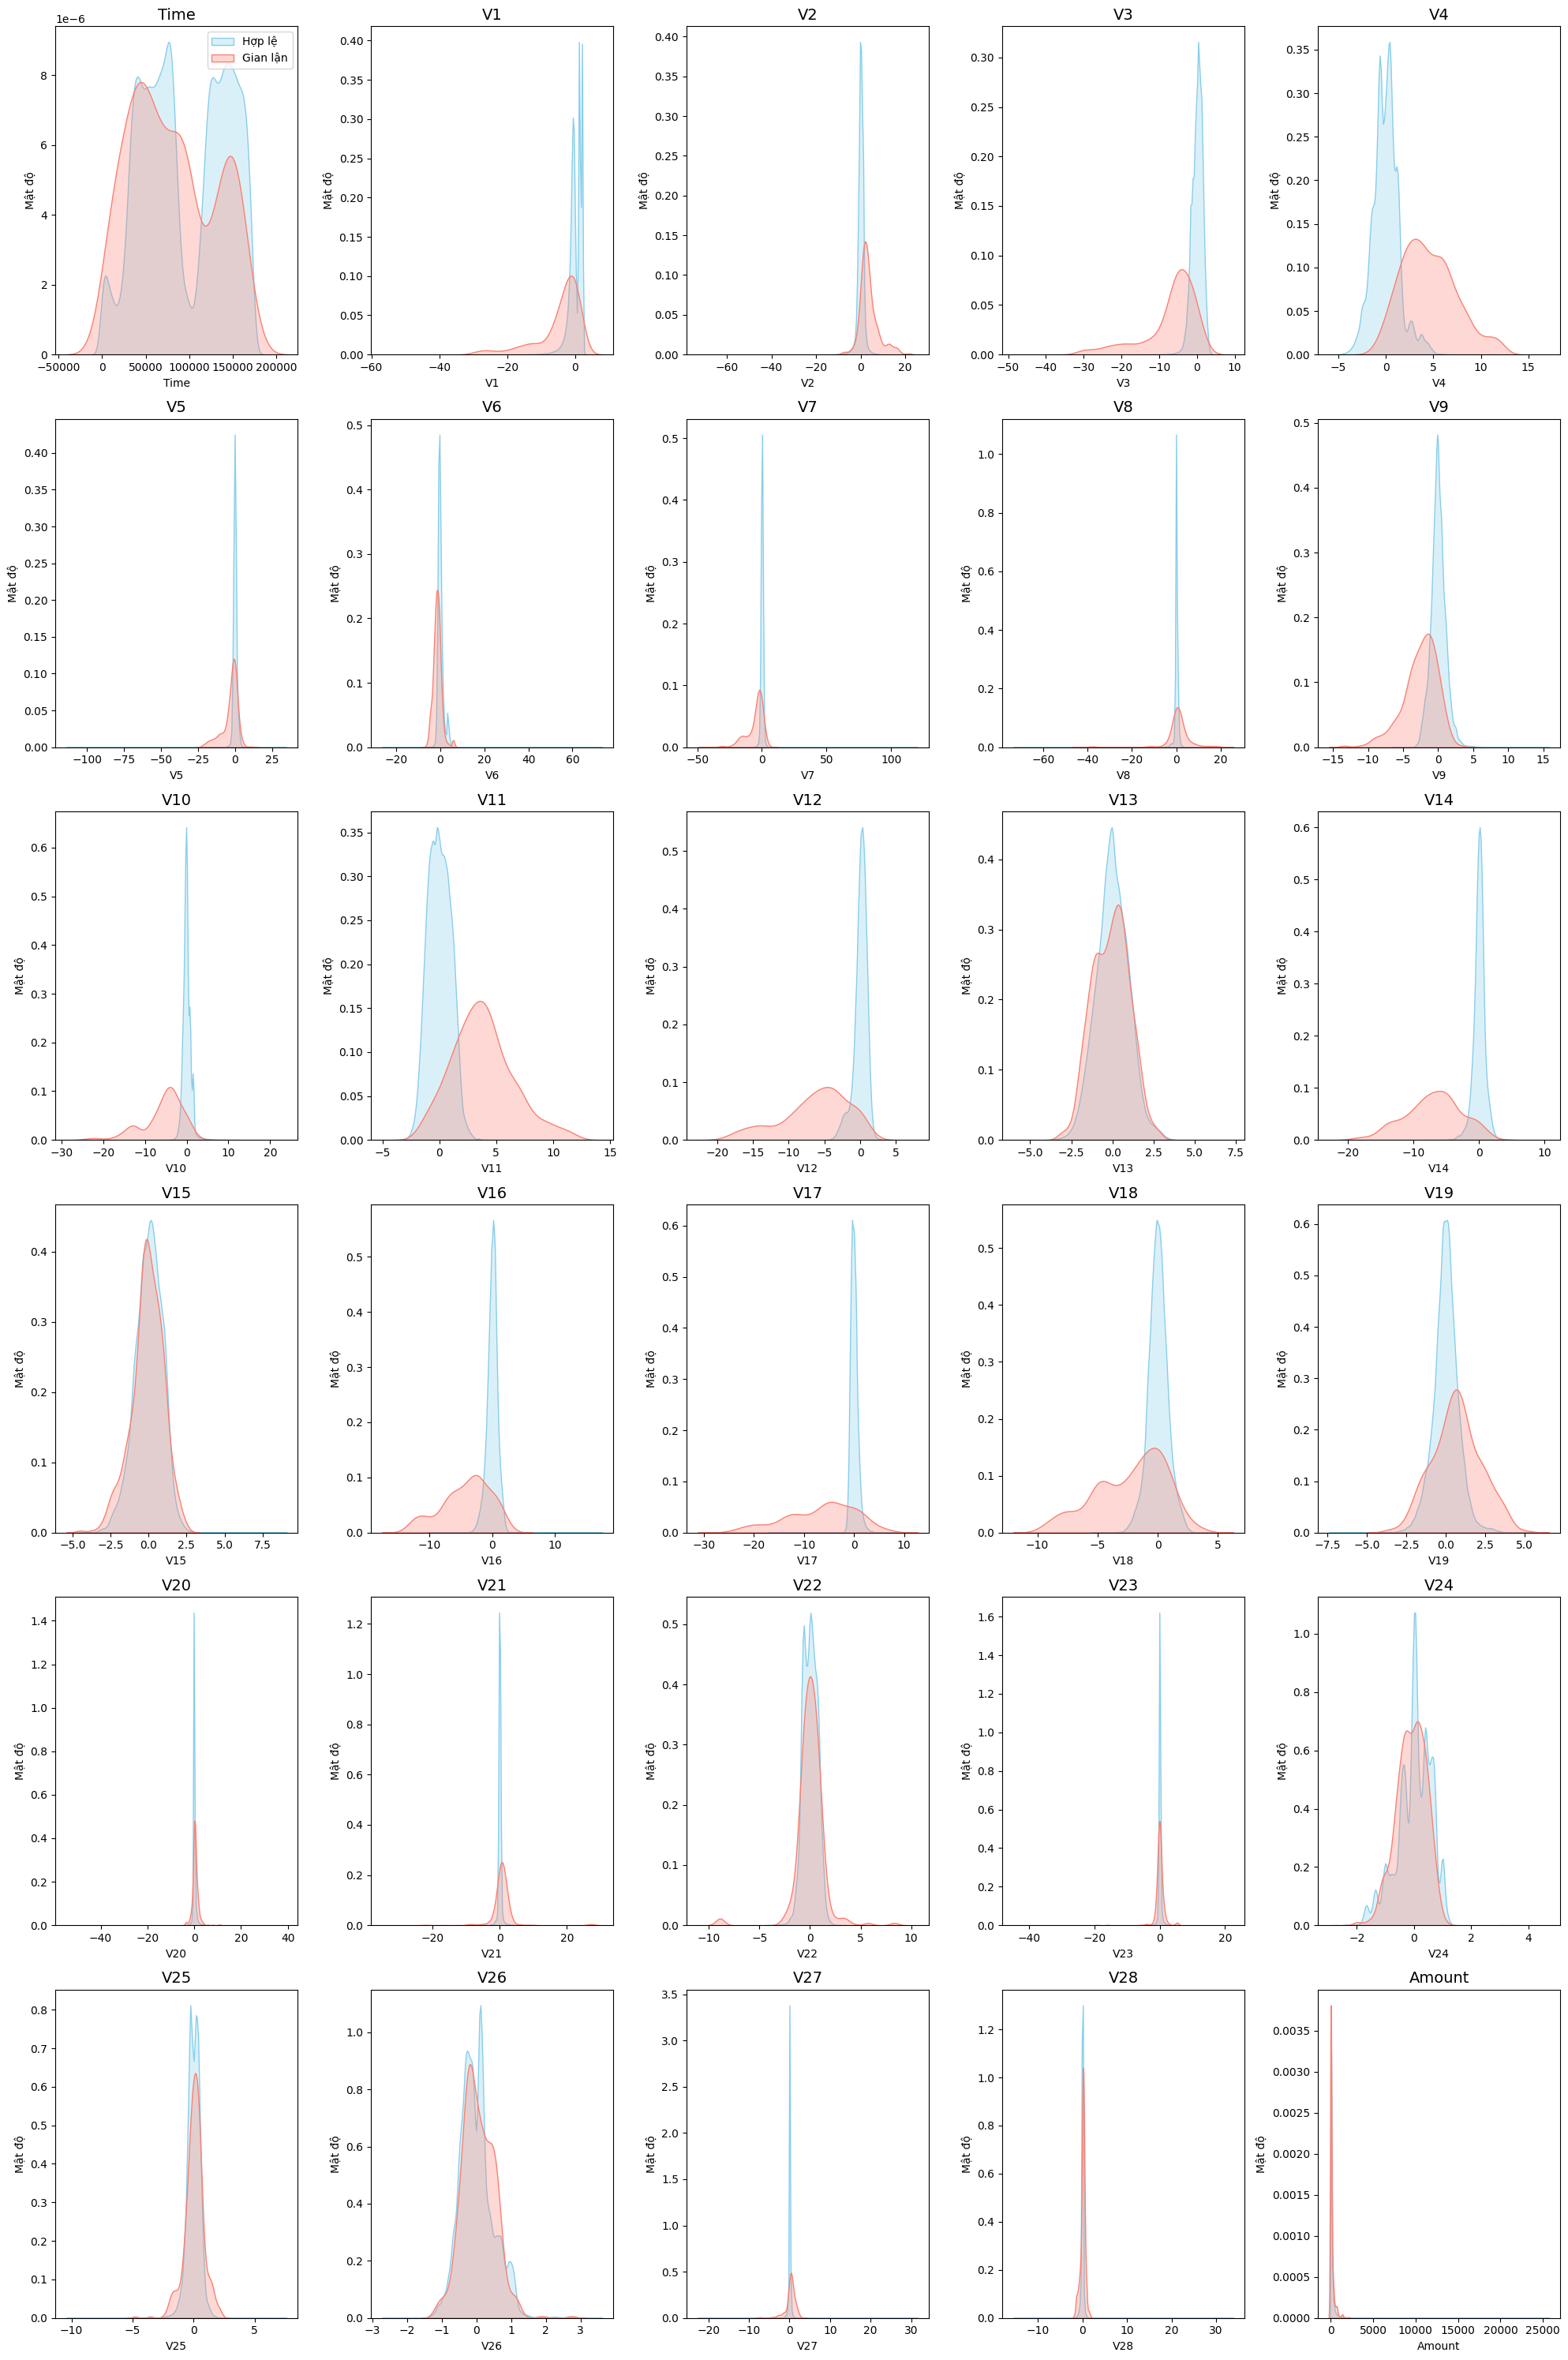

In [8]:
df_legit = df[df['Class'] == 0]
df_fraud = df[df['Class'] == 1]

cols = [c for c in df.columns if c != "Class"]
plots_per_row = 5
n_rows = math.ceil(len(cols) / plots_per_row)

fig, axes = plt.subplots(n_rows, plots_per_row, figsize=(20, 5 * n_rows))

if n_rows == 1:
    axes = [axes]

for idx, col in enumerate(cols):
    r = idx // plots_per_row
    c = idx % plots_per_row
    ax = axes[r][c]
    
    sns.kdeplot(df_legit[col], ax=ax, fill=True, alpha=0.3, 
                label="Hợp lệ", color="skyblue")
    sns.kdeplot(df_fraud[col], ax=ax, fill=True, alpha=0.3, 
                label="Gian lận", color="salmon")
    
    ax.set_title(col, fontsize=14)
    # ax.set_xlabel(col)
    ax.set_ylabel("Mật độ")
    
    if idx == 0:
        ax.legend()
    else:
        ax.legend().remove()

for empty_idx in range(len(cols), n_rows * plots_per_row):
    r = empty_idx // plots_per_row
    c = empty_idx % plots_per_row
    axes[r][c].axis("off")

plt.tight_layout()
plt.show()

# Tiền xử lí và làm sạch dữ liệu

In [9]:
X = df.drop('Class', axis=1)
y = df['Class']

- Chuyển giá trị của cột "Time" từ giây sang giờ
- Giao dịch có phân bố khác nhau tùy 4 buổi trong ngày, tạo 3 cột biểu thị giá trị nhị phân 0/1 tương ứng với các buổi trong ngày (buổi còn lại sẽ có 3 cột giá trị 0)

In [10]:
def assign_day_segment(hour):
    if 6 <= hour < 12:
        return 'Morning'      # 6h-12h: Buổi sáng
    elif 12 <= hour < 18:
        return 'Afternoon'    # 12h-18h: Buổi chiều
    elif 18 <= hour < 24:
        return 'Evening'      # 18h-24h: Buổi tối
    else:
        return 'Night'        # 0h-6h: Buổi đêm

def compute_time_col(data):
    data['Hour'] = (data['Time'] // 3600) % 24
    data['Day_Segment'] = data['Hour'].apply(assign_day_segment)
    data = pd.get_dummies(data, columns=['Day_Segment'], drop_first=True)
    data['Day_Segment_Evening'] = data['Day_Segment_Evening'].astype(int)
    data['Day_Segment_Morning'] = data['Day_Segment_Morning'].astype(int)
    data['Day_Segment_Night'] = data['Day_Segment_Night'].astype(int)

    return data

X_clean = compute_time_col(X)

- Chia dữ liệu ban đầu thành tập train và test, tỉ lệ 80:20
- Tập train và test được chia đảm bảo tỉ lệ nhãn 0/1 là giống nhau

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y, test_size=0.2, random_state=42, shuffle=True, stratify=y
)

- Scaling dữ liệu về khoảng (0,1)

In [ ]:
scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

# Các phương pháp sampling dữ liệu

In [ ]:
def undersampling_data(X_train, y_train):
    scaler = RandomUnderSampler(random_state=RANDOM_STATE)
    X_train_scaled, y_train_scaled = scaler.fit_resample(X_train, y_train)

    return X_train_scaled, y_train_scaled

In [ ]:
def oversampling_data(X_train, y_train):
    scaler = BorderlineSMOTE()
    X_train_scaled, y_train_scaled = scaler.fit_resample(X_train, y_train)

    return X_train_scaled, y_train_scaled

In [ ]:
def ctgan_data(X_train, y_train):
    fraud_data = X_train[y_train == 1].copy().reset_index(drop=True)
    fraud_data['Class'] = 1
    
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(fraud_data)

    ctgan = CTGANSynthesizer(
        metadata,
        epochs=100,
        batch_size=min(100, len(fraud_data)),
        generator_dim=(128, 128),
        discriminator_steps=2,
        discriminator_dim=(128, 128),
        verbose=True
    )

    # chỉ học trên dữ liệu fraud
    ctgan.fit(fraud_data)

    n_fraud_needed = (y_train == 0).sum() - len(fraud_data)
    synthetic_fraud = ctgan.sample(num_rows=n_fraud_needed)

    X_train_scaled = pd.concat([X_train, synthetic_fraud.drop('Class', axis=1)])
    y_train_scaled = pd.concat([y_train, synthetic_fraud['Class']])

    X_train_scaled, y_train_scaled = shuffle(X_train_scaled, y_train_scaled, random_state=RANDOM_STATE)

    return X_train_scaled, y_train_scaled

In [ ]:
def tvae_data(X_train, y_train):
    fraud_data = X_train[y_train == 1].copy().reset_index(drop=True)
    fraud_data['Class'] = 1
    
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(fraud_data)

    tvae = TVAESynthesizer(
        metadata,
        epochs=100,
        batch_size=500
    )

    # chỉ học trên dữ liệu fraud
    tvae.fit(fraud_data)

    n_fraud_needed = (y_train == 0).sum() - len(fraud_data)
    synthetic_fraud = tvae.sample(num_rows=n_fraud_needed)

    X_train_scaled = pd.concat([X_train, synthetic_fraud.drop('Class', axis=1)])
    y_train_scaled = pd.concat([y_train, synthetic_fraud['Class']])

    X_train_scaled, y_train_scaled = shuffle(X_train_scaled, y_train_scaled, random_state=RANDOM_STATE)

    return X_train_scaled, y_train_scaled

# Mô hình XGBoost

In [ ]:
def get_model():
    
    model = xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric=['aucpr', 'logloss'],
        random_state=42,
        learning_rate=0.4,
        n_estimators=1000,
        tree_method='hist',
        n_jobs=-1,
    )
    
    return model

# Thử các trường hợp Sampling

In [ ]:
def visualize(conf_matrix):
    class_names = [f'Class {i}' for i in range(2)]
    
    plt.figure(figsize=(8, 6))
    
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=True,
        linewidths=0.5,
        linecolor='black'
    )
    
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('Nhãn Thực Tế', fontsize=14)
    plt.xlabel('Nhãn Dự Đoán', fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    plt.show()

## UnderSampling

In [ ]:
model = get_model()
X_sample, y_sample = undersampling_data(X_train_scaled, y_train)

model.fit(X_sample, y_sample)

y_proba = model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_proba >= THRESHOLD).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy:  {accuracy*100:.2f} %')
print(f'Precision: {precision*100:.2f} %')
print(f'Recall:    {recall*100:.2f} %')
print(f'F1 Score:  {f1*100:.2f} %')

visualize(conf_matrix)

## SMOTE

In [ ]:
model = get_model()
X_sample, y_sample = oversampling_data(X_train_scaled, y_train)

model.fit(X_sample, y_sample)

y_proba = model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_proba >= THRESHOLD).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy:  {accuracy*100:.2f} %')
print(f'Precision: {precision*100:.2f} %')
print(f'Recall:    {recall*100:.2f} %')
print(f'F1 Score:  {f1*100:.2f} %')

visualize(conf_matrix)

## CTGAN

In [ ]:
model = get_model()
X_sample, y_sample = ctgan_data(X_train_scaled, y_train)

model.fit(X_sample, y_sample)

y_proba = model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_proba >= THRESHOLD).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy:  {accuracy*100:.2f} %')
print(f'Precision: {precision*100:.2f} %')
print(f'Recall:    {recall*100:.2f} %')
print(f'F1 Score:  {f1*100:.2f} %')

visualize(conf_matrix)

## TVAE

In [ ]:
model = get_model()
X_sample, y_sample = tvae_data(X_train_scaled, y_train)

model.fit(X_sample, y_sample)

y_proba = model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_proba >= THRESHOLD).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy:  {accuracy*100:.2f} %')
print(f'Precision: {precision*100:.2f} %')
print(f'Recall:    {recall*100:.2f} %')
print(f'F1 Score:  {f1*100:.2f} %')

visualize(conf_matrix)